In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline

In [2]:
data = pd.read_csv("processing/merged_data.csv", index_col=[0])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,componentindex_249.0,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp
1.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
3.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4.0,0,1,1,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
5.0,0,1,1,1,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1


In [3]:
data['infection_status'].value_counts()

0    90
1    81
Name: infection_status, dtype: int64

So we have 90 unifected samples and 81 infected samples, of course it would be better to have more, but let's explore some different predictive models.

## Logistic Regression
We can start by looking at faeture columns that highly correlate with the infection status.

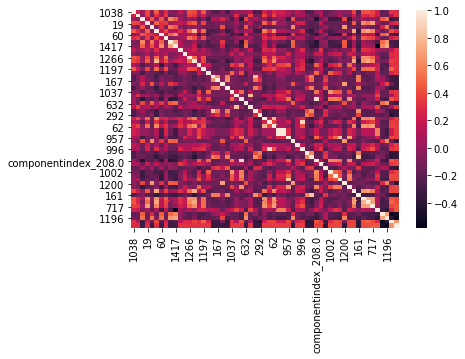

In [4]:
corrmat = data.corr()
sorted_corrs = corrmat['infection_status'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat2 = data[strong_corrs.index].corr()
sns.heatmap(corrmat2)
plt.show()

In [5]:
strong = list(strong_corrs.sort_values(ascending=False).index)

#the top feature is infection_status so we remove that 
top10 = strong[1:11]
top25 = strong[1:26]
strong = strong[1:]
len(strong)

56

In [6]:
def log_reg(df, features):
    df1 = df.copy()
    model = LogisticRegression()
    model.fit(df1[features], df1["infection_status"])
    labels = model.predict(df1[features])
    df1['labels'] = labels
    matches = df1["labels"] == df1["infection_status"]
    correct_predictions = df1[matches == True]
    false_predictions = df1[matches == False]
    accuracy = len(correct_predictions) / len(df1)
    return df1, accuracy, false_predictions

In [7]:
top10_df, top10_acc, top10_false = log_reg(data,top10)
top25_df, top25_acc, top25_false = log_reg(data,top25)
strong_df, strong_acc, strong_false = log_reg(data,strong)

print("The accuracy for top10 is: ", top10_acc)
print("The accuracy for top25 is: ", top25_acc)
print("The accuracy for all strongly correlated features is: ", strong_acc)

The accuracy for top10 is:  0.9181286549707602
The accuracy for top25 is:  0.9532163742690059
The accuracy for all strongly correlated features is:  0.9766081871345029


To be honest, this is a little surprising even though we used the same dataset to train and test. It's surprising because our initial analysis of the metabolites made it seem like there wasn't a whole lot to separate infected from non-infected. In addition, we're looking at different forms of parasite and different sections of the gut, so the fact that there is good accuracy across so many different samples is impressive. Maybe there's something consistent across those samples. A few next steps:

- let's look at which samples were incorrect in the above models;
- let's split the data into test and train and try again on unseen data, with cross validation.

In [8]:
top10_false

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
1.0,0,1,0,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,1
19.0,0,1,1,1,0,0,0,1,1,0,...,0,2,0,1,0,0,0,0,1,1
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
48.0,0,1,1,1,0,0,1,1,1,0,...,0,1,1,0,1,0,0,0,1,0
62.0,0,1,1,1,0,0,0,1,1,0,...,0,2,1,0,0,1,0,0,1,0
66.0,0,1,1,1,0,0,0,1,1,0,...,0,3,1,0,1,0,0,0,1,0
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
76.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,1,0,0,1,0,0,1
77.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1


In [9]:
top25_false

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
62.0,0,1,1,1,0,0,0,1,1,0,...,0,2,1,0,0,1,0,0,1,0
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
76.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,1,0,0,1,0,0,1
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
133.0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1


In [10]:
strong_false

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
37.0,0,1,1,1,0,0,0,1,1,1,...,0,0,1,1,0,0,0,0,1,0
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
76.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,1,0,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1


Interestingly, the model clearly has trouble with the starved samples - those samples where insects were dissected before being allowed to feed.

### Splitting into train and test datasets

In [12]:
shuffled_rows = np.random.permutation(data.index)
shuffled_data = data.loc[shuffled_rows]

split_index = round(0.8*(len(shuffled_data)))
train = shuffled_data[:split_index]
test = shuffled_data[split_index:]


In [13]:
#We can modify this to accept train and test datasets
def log_reg(train, test_df, features):
    
    train_y = train['infection_status']
    train_X = train.drop(['infection_status'], axis=1)
    
    test_y = test['infection_status']
    test_X = test.drop(['infection_status'], axis=1)

    model = LogisticRegression()
    model.fit(train_X[features], train_y)
    labels = model.predict(test_X[features])
    results_df = test_df.copy()
    results_df['labels'] = labels
    matches = results_df["labels"] == test_y
    correct_predictions = results_df[matches == True]
    false_predictions = results_df[matches == False]
    accuracy = len(correct_predictions) / len(test_X)
    return accuracy, false_predictions

In [14]:
top10_acc_test, top10_false_test = log_reg(train,test,top10)
top25_acc_test, top25_false_test = log_reg(train,test,top25)
strong_acc_test, strong_false_test = log_reg(train,test,strong)

print("The accuracy for top10 is: ", top10_acc_test)
print("The accuracy for top25 is: ", top25_acc_test)
print("The accuracy for all strongly correlated features is: ", strong_acc_test)

The accuracy for top10 is:  0.8834355828220859
The accuracy for top25 is:  0.9079754601226994
The accuracy for all strongly correlated features is:  0.9079754601226994


In [15]:
top10_false_test

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
74.0,0,0,1,1,0,0,0,1,1,0,...,1,-1,0,0,0,1,1,0,0,1
136.0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,1,0,1
133.0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1
46.0,0,1,1,1,0,0,0,1,1,0,...,0,1,1,1,0,0,0,0,1,0
66.0,0,1,1,1,0,0,0,1,1,0,...,0,3,1,0,1,0,0,0,1,0
58.0,0,0,1,1,0,0,0,1,1,0,...,0,2,1,1,0,0,0,0,1,0
48.0,0,1,1,1,0,0,1,1,1,0,...,0,1,1,0,1,0,0,0,1,0
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1


In [16]:
top25_false_test

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
102.0,0,1,0,0,0,0,0,1,1,0,...,1,1,1,0,1,0,0,1,0,0
74.0,0,0,1,1,0,0,0,1,1,0,...,1,-1,0,0,0,1,1,0,0,1
154.0,0,1,1,1,0,0,0,1,1,0,...,0,2,0,1,0,0,0,1,0,1
133.0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
142.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1
62.0,0,1,1,1,0,0,0,1,1,0,...,0,2,1,0,0,1,0,0,1,0


In [17]:
strong_false_test

,0,1,2,3,4,5,6,7,8,9,...,componentindex_251.0,time_point,infection_status,gut_section_AM,gut_section_H,gut_section_PM,R.prolixus_starved,T.cruzi_epi,T.cruzi_tryp,labels
75.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
38.0,0,1,1,1,0,0,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
80.0,1,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,0,1,1,0,0,1
154.0,0,1,1,1,0,0,0,1,1,0,...,0,2,0,1,0,0,0,1,0,1
133.0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,1
66.0,0,1,1,1,0,0,0,1,1,0,...,0,3,1,0,1,0,0,0,1,0
78.0,0,0,1,1,0,0,0,1,1,0,...,0,-1,0,0,1,0,1,0,0,1
73.0,1,0,1,1,0,1,0,1,1,0,...,1,-1,0,1,0,0,1,0,0,1
142.0,0,1,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1
88.0,0,0,0,1,0,0,0,1,1,0,...,0,0,1,1,0,0,0,1,0,0


Out of curiosity, let's see what happens if we use all features.

In [18]:
all_features = list(data.columns)
all_features.remove('infection_status')

In [24]:
all_acc_test, all_false_test = log_reg(train,test,all_features)

print("The accuracy for all_features is:", all_acc_test)

The accuracy for all_features is: 0.5766871165644172


It looks like our model is clearly overfitting. This is somewhat expected with 1558 features and only 171 samples.

Let's move on to perform cross validation.

In [25]:
def train_and_CV_log_reg(cols):
    
    features = data[cols]
    accuracies = []
    kf = KFold(n_splits = 5, shuffle=True, random_state=3)
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = data['infection_status'].iloc[train_index], data['infection_status'].iloc[test_index]
        lg = LogisticRegression()
        lg.fit(X_train, y_train)
        predictions = lg.predict(X_test)
        
        accuracy = accuracy_score(y_test, predictions)
        
        accuracies.append(accuracy)
    avg_acc = np.mean(accuracies)
    max_acc = np.max(accuracies)
    return avg_acc, max_acc

In [26]:
top10_avg_acc, top10_max_acc = train_and_CV_log_reg(top10)
top25_avg_acc, top25_max_acc = train_and_CV_log_reg(top25)
strong_avg_acc, strong_max_acc = train_and_CV_log_reg(strong)
print("Using the top 10 features returns a maximum of", top10_max_acc, "and an average accuracy of", top10_avg_acc)
print("Using the top 25 features returns a maximum of", top25_max_acc, "and an average accuracy of", top25_avg_acc)
print("Using the top correlated features returns a maximum of", strong_max_acc, "and an average accuracy of", strong_avg_acc)

Using the top 10 features returns a maximum of 0.9411764705882353 and an average accuracy of 0.8887394957983193
Using the top 25 features returns a maximum of 0.9705882352941176 and an average accuracy of 0.9357983193277309
Using the top correlated features returns a maximum of 0.9705882352941176 and an average accuracy of 0.924033613445378


It looks like 25 features is enough for the logistic regression model. For a first try, an average of 93.5% is very satisfactory.

## Feature importance
Here we can look at the importance of each of the features in defining the model.

In [28]:
train_y = train['infection_status']
train_X = train.drop(['infection_status'], axis=1)
    
test_y = test['infection_status']
test_X = test.drop(['infection_status'], axis=1)

In [39]:
lg = LogisticRegression()
lg.fit(train_X[top25], train_y)
importance = lg.coef_[0]
# summarize feature importance

for feature in zip(top25, importance):
    print('Feature:', feature[0]+',', 'Score:', feature[1])

Feature: 787, Score: 0.28613108200469195
Feature: 1196, Score: -0.5139430785639612
Feature: 208, Score: -0.2862064329280399
Feature: 187, Score: 0.23062334464203138
Feature: 717, Score: 0.43001875640733206
Feature: 993, Score: 0.43001875640733206
Feature: 81, Score: 0.11932121333213241
Feature: 161, Score: 0.0
Feature: 959, Score: 0.4946280570139866
Feature: 952, Score: 0.23053109548521122
Feature: 1200, Score: -0.3328420653988515
Feature: componentindex_51.0, Score: 0.01923967062662664
Feature: 991, Score: 0.23053109548521122
Feature: 1002, Score: 0.39375068967129817
Feature: 18, Score: -0.14989519064468362
Feature: 927, Score: 0.4134779702393791
Feature: componentindex_208.0, Score: 0.39375068967129817
Feature: 157, Score: 0.0
Feature: 316, Score: 0.0
Feature: 996, Score: 0.39464207969909704
Feature: 1006, Score: -0.18110101316510965
Feature: 1288, Score: -0.3328420653988515
Feature: 957, Score: -0.2915501216053932
Feature: 486, Score: 0.0
Feature: componentindex_251.0, Score: 0.0


We remember that our predictions are 0 (unexposed) or 1 (exposed to parasite). These values are both positive and negative numbers, with positive numbers indicating features that predict class 1 and negative numbers designated to features predicting class 0. Let's try and visualise this now.

In [46]:
data = []
for feature in zip(top25, importance):
    data.append(feature)

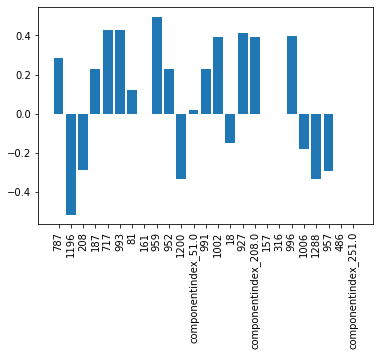

In [49]:
x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
plt.bar(x_val,y_val)
plt.xticks(rotation=90)
plt.show()